In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

def load_logs(file_path: str):
    file = open(file_path)
    return pickle.load(file)

In [5]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'input_rate': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    algs = []
    num_nodes_list = []
    cloud_costs = []
    waiting_times = []
    for key, finished_jobs in simulator_results.items():
        token_list = key.split('-')
        if len(token_list)>0:
            alg =  '-'.join(token_list[:-1])
            input_rate = token_list[-1]
        else:
            alg = f'{token_list[0]}-{token_list[1]}'
            input_rate = token_list[2]
        input_rate = int(input_rate)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        count = 0
        for idx in range(len(finished_jobs['idx'])):
            if idx < 2000 or idx > len(finished_jobs['idx']) - 2000:
                continue
            arrival = finished_jobs['arrival'][idx]
            start = finished_jobs['start'][idx]
            if finished_jobs['state'][idx] != 'LOCAL':
                runtime = finished_jobs['runtime'][idx]
                cloud_cost += finished_jobs['num_gpus'][idx] * runtime
                if finished_jobs['state'][idx] == 'FILTER-CLOUD':
                    total_waiting_time += start - arrival
                else:
                    deadline = finished_jobs['deadline'][idx]
                    total_waiting_time += deadline - runtime - arrival
            else:
                total_waiting_time += start - arrival
            count+=1
        avg_waiting_time = total_waiting_time / count
        df = pd.DataFrame(data={'alg': [alg], 'input_rate': [input_rate], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def plot_cost_and_waiting_graph(results_df, normalized=False, plot_twin=True):
    if plot_twin:
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
    else:
        # Get current default figsize
        default_figsize = plt.rcParams.get('figure.figsize')
        # Set the new figsize as the default
        fix, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*default_figsize[0], 2*default_figsize[1]))

    x_axis = 'normalized_input_rate'
    results_df['normalized_input_rate'] = results_df['input_rate']*13.580799152777779/(64*8)
    label_x = 'Normalized Input Rate'
    
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = x_axis, y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel='Cloud Price')
        if plot_twin:
            style = '--'
        else:
            style = None
        a2 = grp.plot(x = x_axis, y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, xlabel=label_x, \
                      ylabel = 'Avg. Waiting Time', style=style)
    ax.set_ylim(bottom=0.0)
    
    if plot_twin:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
                  bbox_to_anchor=(0, 1.00, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
    else:
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, ncol=len(labels), \
                  bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
        ax2.grid(True, which='both')
    plt.show()  

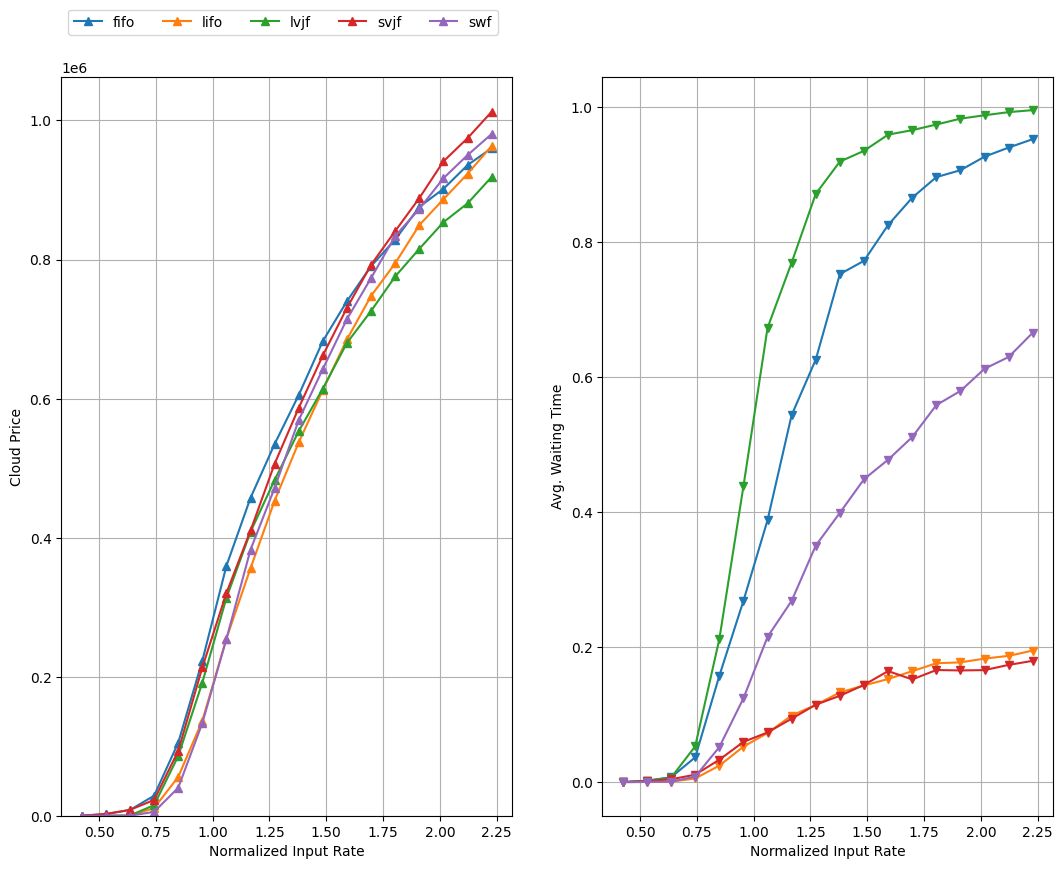

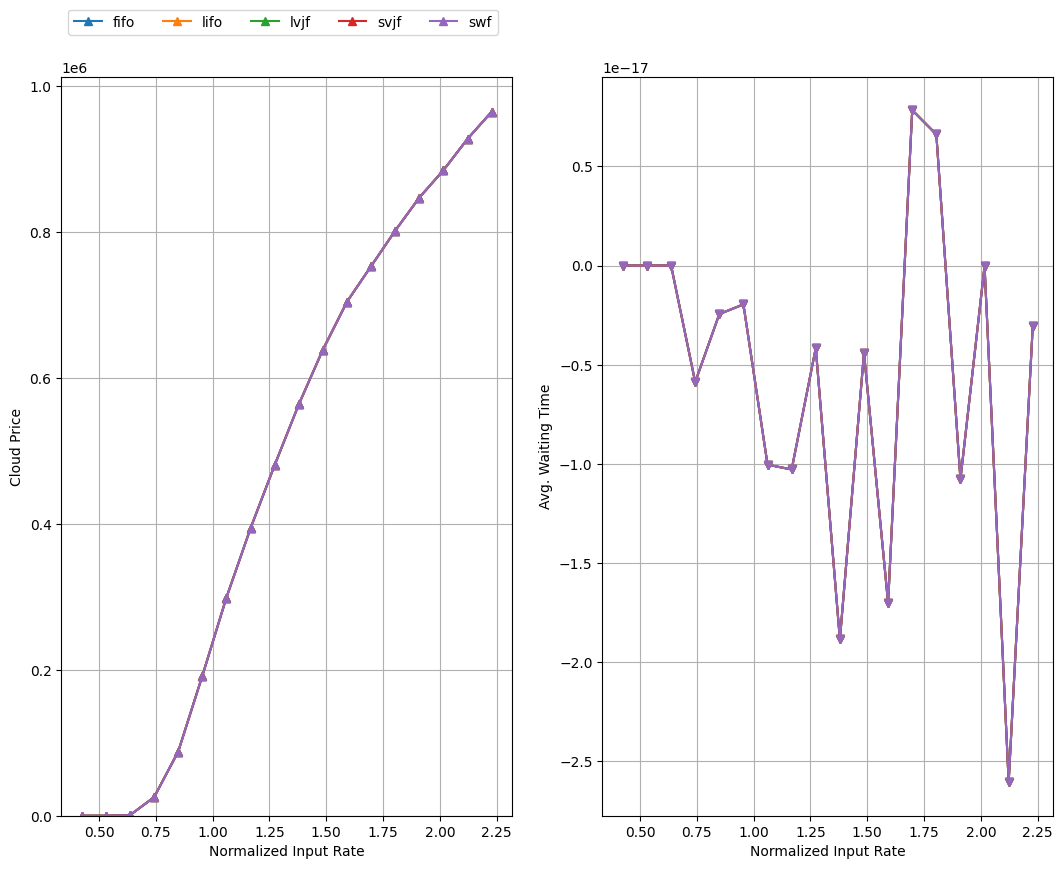

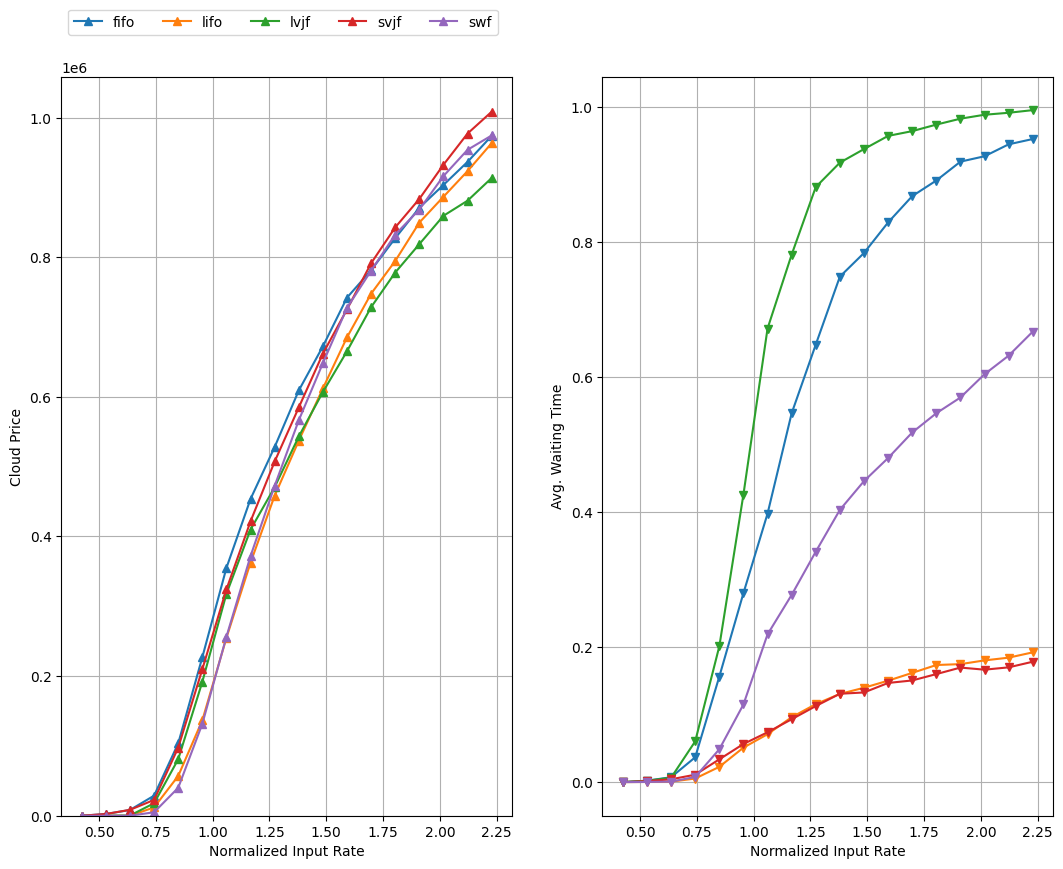

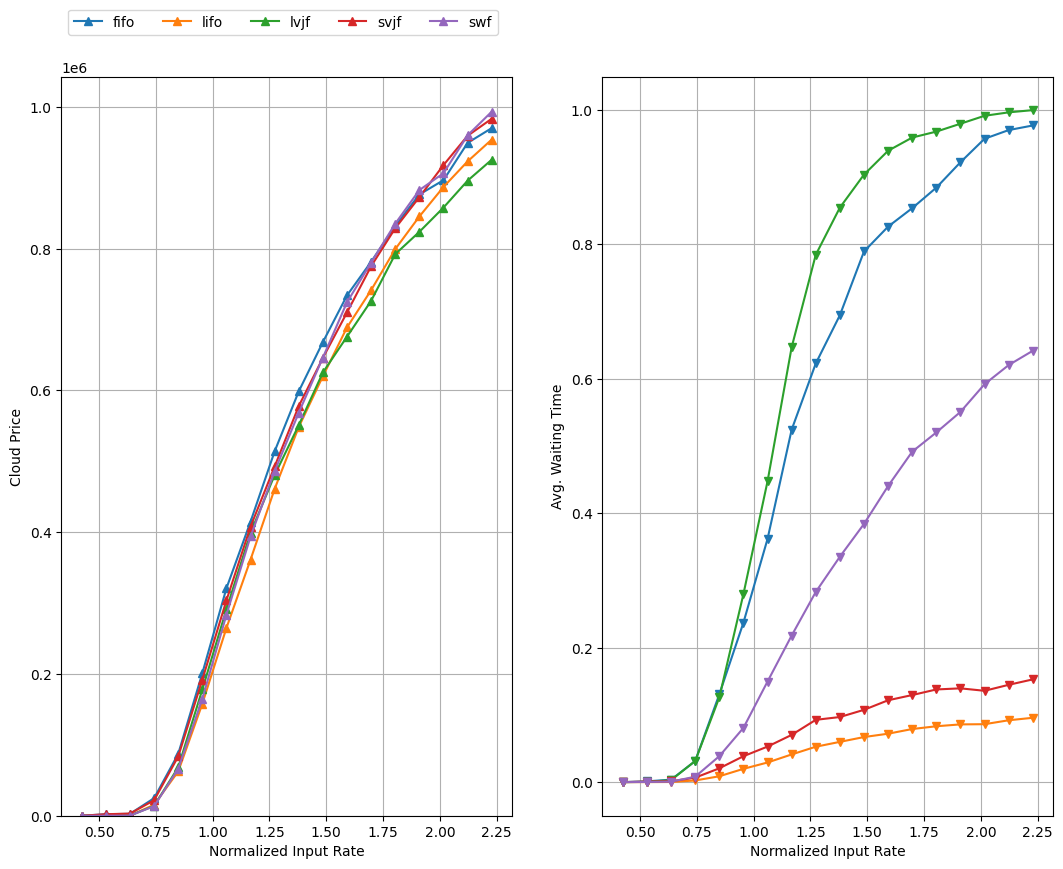

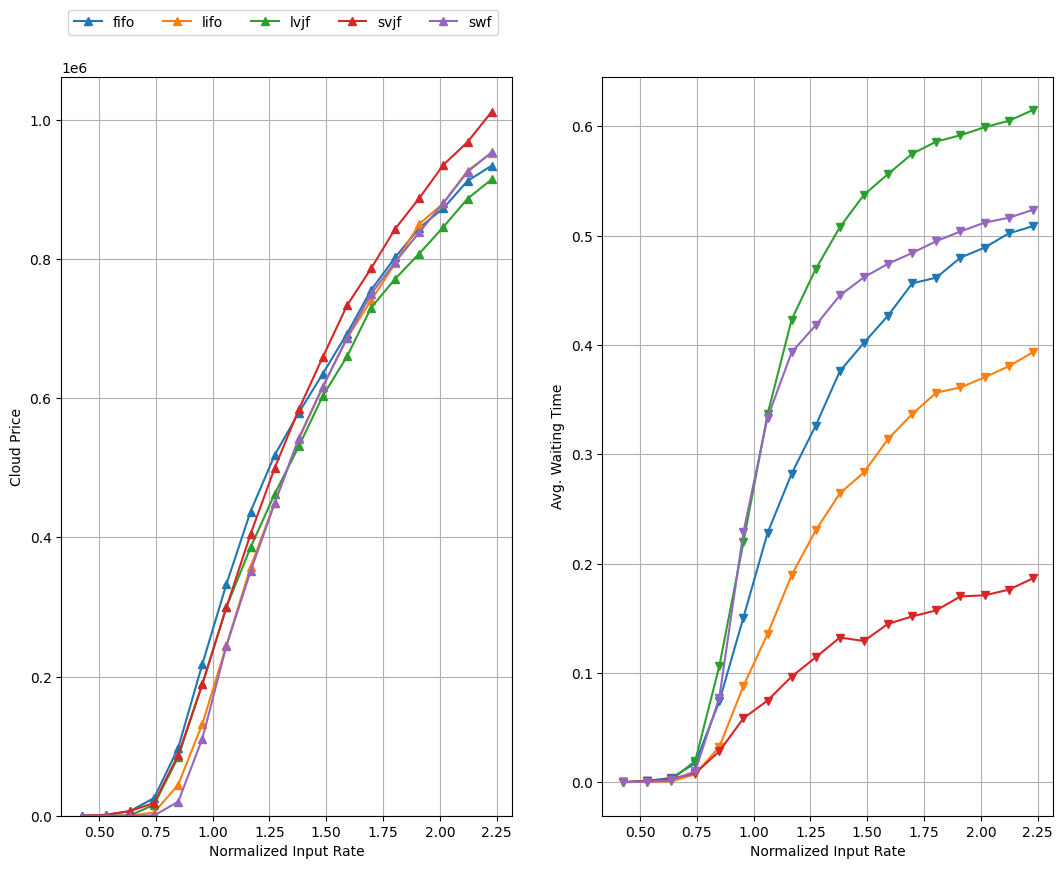

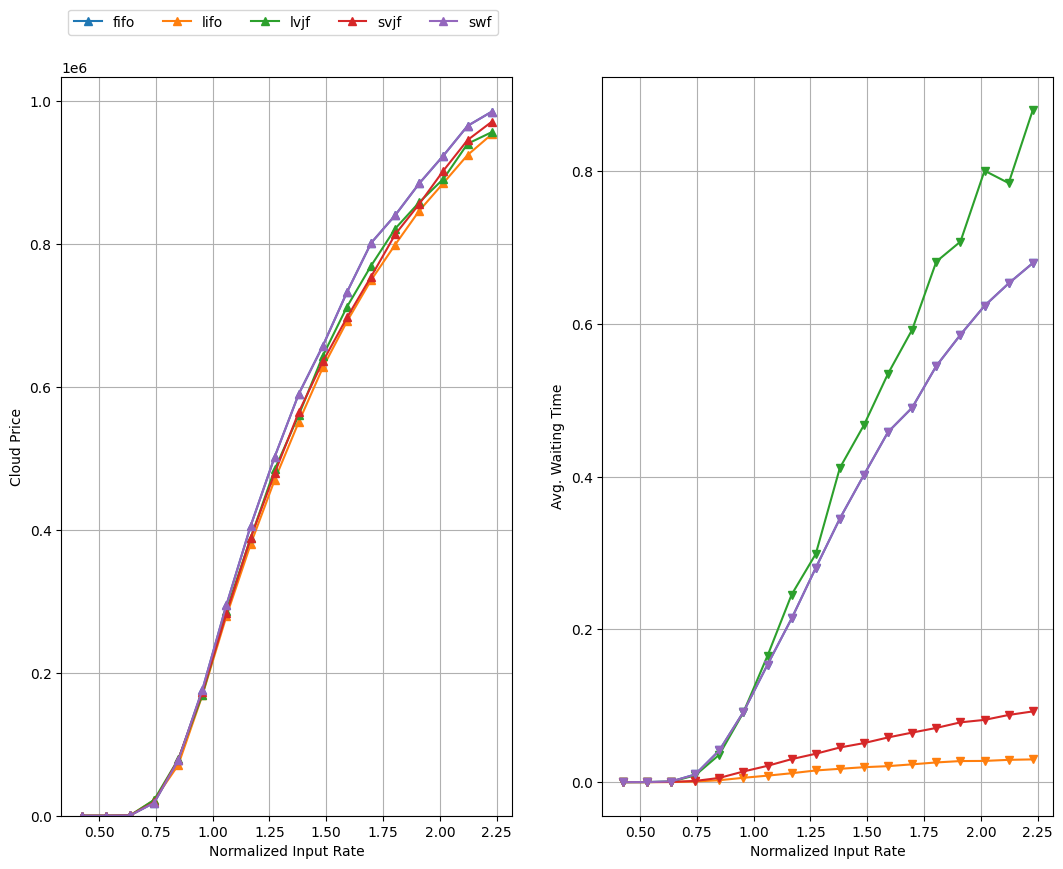

In [3]:

results={}
hybrid_results_df = pd.DataFrame()
for func_type in ['exact_log', 'nowait', 'linear', 'log', 'quad', 'constant']:
    num_nodes = 64
    file = open(f'logs/poisson/vary_capacity/{func_type}_philly_cont.log', 'rb')
    results[func_type] = pickle.load(file)
    temp_df = create_results_df(results[func_type])
    temp_df['deadline'] = func_type
    plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

In [6]:
avg_job_volume_rate = np.mean(results['linear']['fifo-24']['num_gpus']* results['linear']['fifo-24']['runtime'])

/tmp/ipykernel_35352/1512212956.py:50: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.yaxis.grid(False, color='#DDDDDD')
/tmp/ipykernel_35352/1512212956.py:51: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(False, color='#DDDDDD')


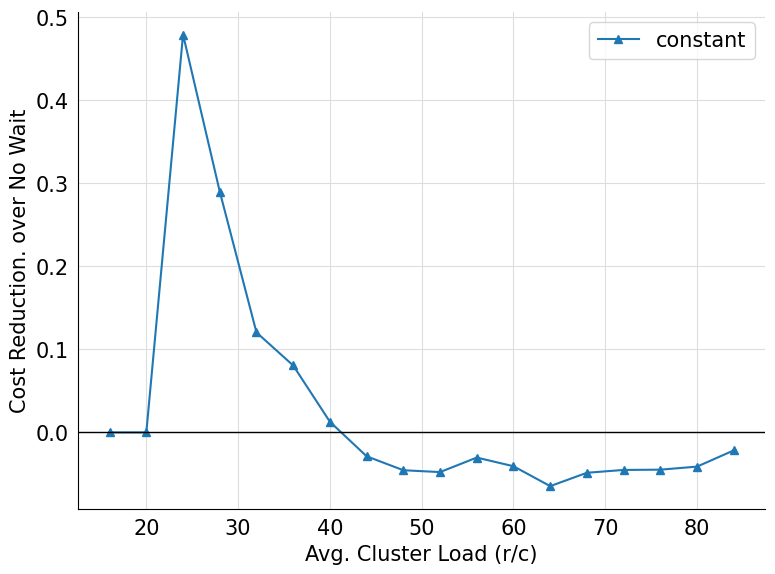

In [16]:
def plot_normalized_cost_deadline(results_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
#     total_job_gpu_hours = 1155998.77277777
#     job_makespan = 2559.3205555555555
#     results_df['normalized_input_rate'] = total_job_gpu_hours/(job_makespan*results_df['input_rate']*8)
    results_df['normalized_input_rate'] = results_df['input_rate']* avg_job_volume_rate/(64*8)
    results_df = results_df[results_df['alg']=='fifo']
    baseline_df =  results_df[results_df['deadline']=='nowait']

    #results_df = results_df[results_df['deadline']!='linear']
    results_df = results_df[results_df['deadline']=='constant']
    results_df = results_df[results_df['deadline']!='exact_log']
    #results_df = results_df[results_df['deadline']!='linear']
    #results_df = results_df[results_df['alg']!='fifo']
    
    diff_df = pd.merge(baseline_df,
               results_df, left_on=['input_rate', 'normalized_input_rate'],right_on=['input_rate', 'normalized_input_rate'])
    
    def cost_multiplier(row):
        baseline_cost = row['cost_x']
        cost = row['cost_y']
        #return baseline_cost - cost
        if baseline_cost == 0 and cost==0:
            return 0
        elif cost==0:
            return 1
        elif baseline_cost ==0:
            return -1
#         print(cost, baseline_cost)
        return max(-1, 1 - (cost/baseline_cost))
    
    diff_df['cost_diff'] = diff_df.apply(cost_multiplier, axis=1)
    plt.rcParams.update({'font.size': 15})
    for idx, (label, grp) in enumerate(diff_df.groupby('deadline_y')):
        a1 = grp.plot(x = 'normalized_input_rate', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel='Avg. Cluster Load (r/c)', \
                ylabel='Cost Reduction. over No Wait') # w(·)∝k
    lines, labels = ax.get_legend_handles_labels()
    ax.legend()
    #ax.legend(labels=['w(·)∝log(k)', 'w(·)∝k²'],loc='lower right')
    ax.axhline(linewidth=1, color="black")
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    #ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(False, color='#DDDDDD')
    ax.xaxis.grid(False, color='#DDDDDD')
    
    fig.tight_layout()
    plt.savefig('figures/constant_ablate.pdf')
    
#     ax.legend(lines, labels, ncol=4, \
#               bbox_to_anchor=(0, 0.96, 1, 0.2), loc="center")
    #ax.grid(True, which='both')
    plt.show()

plot_normalized_cost_deadline(hybrid_results_df)

In [43]:
results.keys()

dict_keys(['exact_log', 'linear'])

/tmp/ipykernel_47317/2353494102.py:34: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.yaxis.grid(False, color='#EEEEEE')


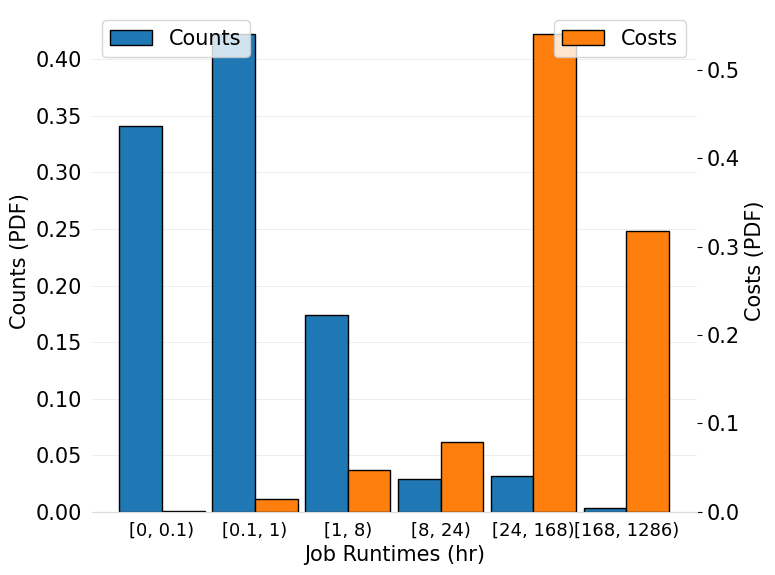

In [43]:
def plot_job_statistics(jobs, bins=None):
    jobs = copy.deepcopy(jobs)
    runtime = jobs['runtime']
    if bins is None:
        bins = [0, 0.1, 1, 8, 24, 168, math.ceil(max(runtime))]
    
    counts = [0] * (len(bins)-1)
    costs = [0] * (len(bins)-1)
    for job_idx, r in enumerate(runtime):
        for bin_idx in range(len(bins)-1):
            if r >= bins[bin_idx] and r < bins[bin_idx+1]:
                counts[bin_idx] +=1
                costs[bin_idx] += r * jobs['num_gpus'][job_idx]
    counts = [c/sum(counts) for c in counts]
    costs = [c/sum(costs) for c in costs]
    # Generated by ChatGPT
    bar_width = 0.46
    plt.rcParams.update({'font.size': 15})
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()
    ax2.set_yticks([])
    
    ax1.grid(True)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_color('#DDDDDD')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_color('#DDDDDD')
    ax1.tick_params(bottom=False, left=False)
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(False, color='#EEEEEE')
    ax1.xaxis.grid(False)
    ax2.tick_params(bottom=True, left=False)
    ax2.set_axisbelow(True)
    ax2.xaxis.grid(False)
    
    
    x = np.arange(len(bins)-1)
    ax1.set_ylabel('Counts (PDF)')
    ax1.bar(x - bar_width/2, counts, width=bar_width, edgecolor='black', color='tab:blue')
    ax2.set_ylabel('Costs (PDF)')
    ax2.bar(x + bar_width/2, costs, width=bar_width, edgecolor='black', color='tab:orange')
    #ax1.set_yticks(np.arange(0, np.max(np.array(counts))+1, 10000))
    ax2.set_yticks(np.arange(0, np.max(np.array(costs)), 0.1))
    ax1.legend(['Counts'], loc='upper left')
    ax2.legend(['Costs'], loc='upper right')
    
    ax1.tick_params(axis='x', which='major', labelsize=13)
    #ax1.tick_params(axis='both', which='minor', labelsize=8)

    ax1.set_xlabel('Job Runtimes (hr)')
    # set the x-axis tick labels
    plt.xticks(x, [f'[{bins[bin_idx]}, {bins[bin_idx+1]})' for bin_idx in range(len(x))])
    # show the plot
    fig.tight_layout()
    plt.savefig('figures/philly_count_costs.pdf')
    plt.show()

plot_job_statistics(results['exact_log']['fifo-24'])

Text(0, 0.5, 'Cost')

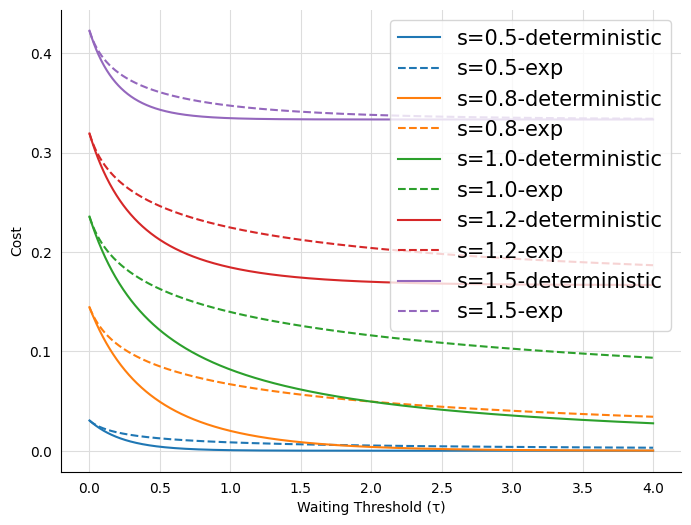

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

def renege_probability(lmbda, c, mu, tau):
    r = lmbda/mu
    if r==c:
        numerator = (c**c / factorial(c)) * np.exp(-mu * tau * (c - r))
        denominator_sum = sum([(c**k / factorial(k)) for k in range(c)])
        last_term = (r**c / factorial(c)) * (1 + c*mu*tau)
        denominator = denominator_sum + last_term
        return numerator/denominator
    numerator = (r**c / factorial(c)) * np.exp(-mu * tau * (c - r))
    denominator_sum = sum([(r**k / factorial(k)) for k in range(c)])
    last_term = (r**c / factorial(c)) * (r * np.exp(-mu * tau * (c - r)) - c) / (r - c)
    denominator = denominator_sum + last_term
    return numerator / denominator


def average_wait_time(lmbda, c, mu, tau, with_balk=False):
    intensity = lmbda/(c*mu)
    
    delta = (c*mu - lmbda)
    p = (lmbda/mu)**c/ (sum([((lmbda/mu)**k / factorial(k)) for k in range(c+1)])*factorial(c))
    beta = (c*mu*p)/(1-p)
    if intensity!=1:
        alpha = (beta*(1/delta - np.exp(-delta*tau) * lmbda/(delta*c*mu)) + 1)**-1
    elif intensity==1:
        alpha = lmbda / (lmbda + beta * lmbda * tau + beta)
    
    r = (alpha * beta * np.exp(-delta * tau)) / (c*mu)
    
    if intensity!=1:
        avg_wait_time = (alpha*beta*(1-delta*tau*np.exp(-delta*tau) - np.exp(-delta*tau)))/(delta)**2 + r*tau
    else:
        avg_wait_time = alpha*beta*(tau)**2/2 + r*tau
    
    if with_balk:
        avg_wait_time -= r*tau
    
    return avg_wait_time

from scipy.special import gammainc, gammaincc, gamma
def renege_probability_exp(lmbda, c, mu, tau):
    r = lmbda/mu
    long_sum = sum([(r**k / factorial(k)) for k in range(c)])
    z = (np.exp(r*mu*tau)) * ((r*mu*tau)**(-c*mu*tau)) * gammainc(c*mu*tau + 1, r*mu*tau) * gamma(c*mu*tau+1)
    numerator = long_sum + ((r**(c-1))/factorial(c-1))*z
    denominator = long_sum + ((r**(c))/factorial(c))*(1+z)
    return 1 - numerator / denominator

c = 8
mu = 1
tau_values = np.linspace(0, 4, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for lmbda in [c*0.5, c*0.8, c*1, c*1.2, c*1.5]:
    system_util = lmbda/(mu*c)
    cloud_cost_values = [renege_probability(lmbda, c, mu, tau) for tau in tau_values]
    #jct_values = [average_wait_time(lmbda, c, mu, tau) for tau in tau_values]
    p = plt.plot(tau_values, cloud_cost_values, label=f's={system_util}-deterministic')
    
    exp_cloud_cost_values = [renege_probability_exp(lmbda, c, mu, tau) for tau in tau_values]
    #jct_values = [average_wait_time(lmbda, c, mu, tau) for tau in tau_values]
    plt.plot(tau_values, exp_cloud_cost_values, label=f's={system_util}-exp', \
             color=p[0].get_color(), ls='--')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    
plt.xlabel('Waiting Threshold (τ)')
#plt.xlabel('Average Waiting Time')
plt.ylabel('Cost')
# plt.xlabel('Waiting Time (τ/μ)')
# plt.ylabel('Cost Reduction over No Wait')

# fig.tight_layout()
# plt.savefig('figures/theoretical_cost_savings.pdf')
# plt.show()

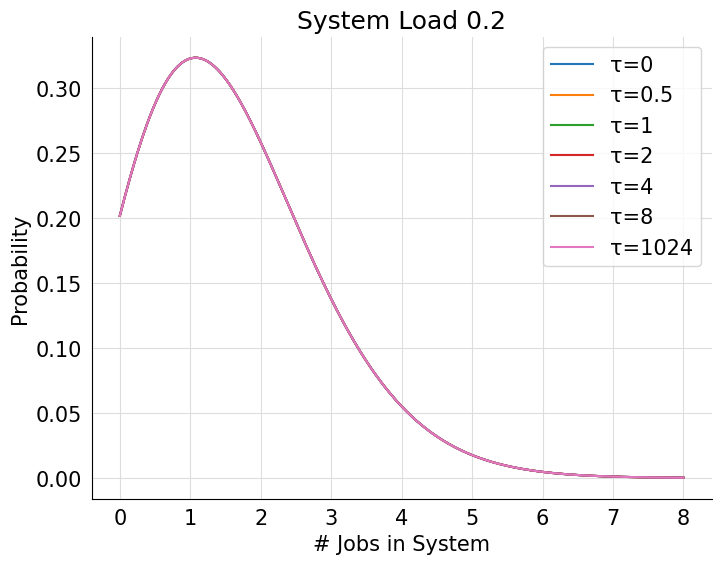

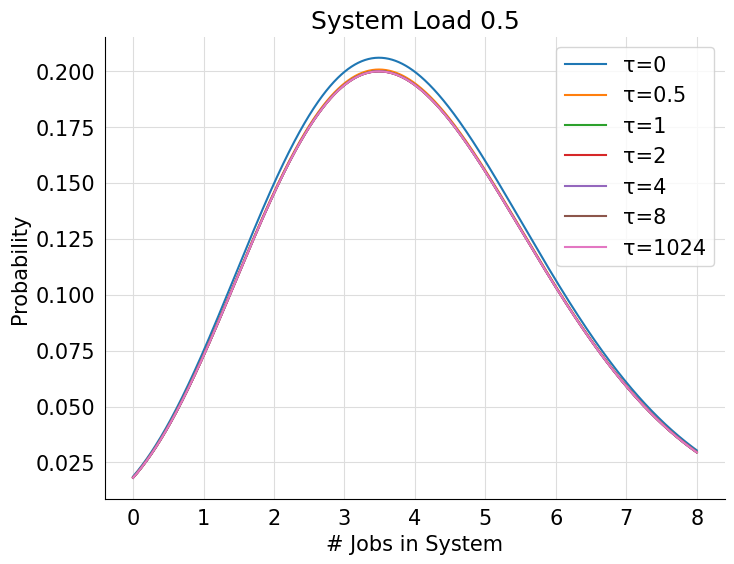

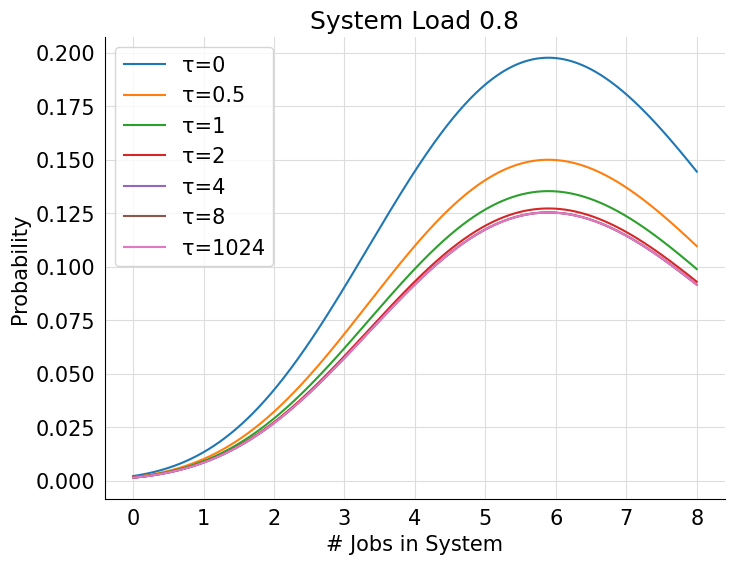

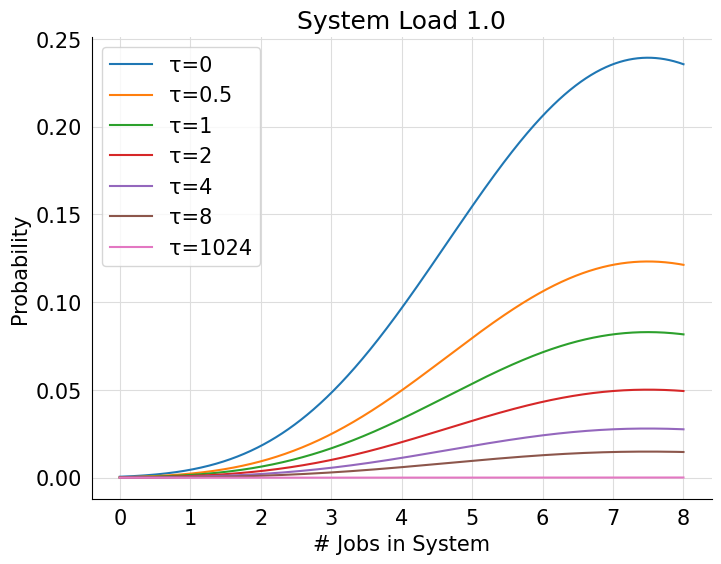

/tmp/ipykernel_12067/3507075241.py:14: RuntimeWarning: overflow encountered in exp
  p0 = summation + (pho**(c+1)/((pho-c)*factorial(c))) * (np.exp(alpha*(pho-c))-1)


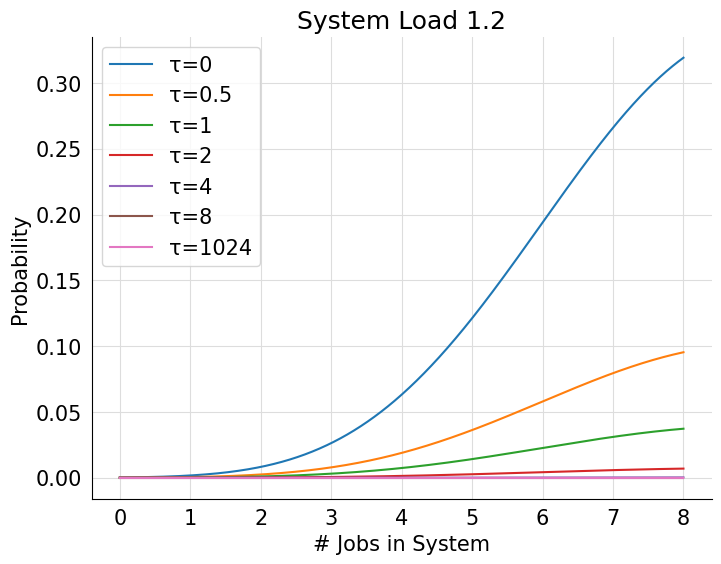

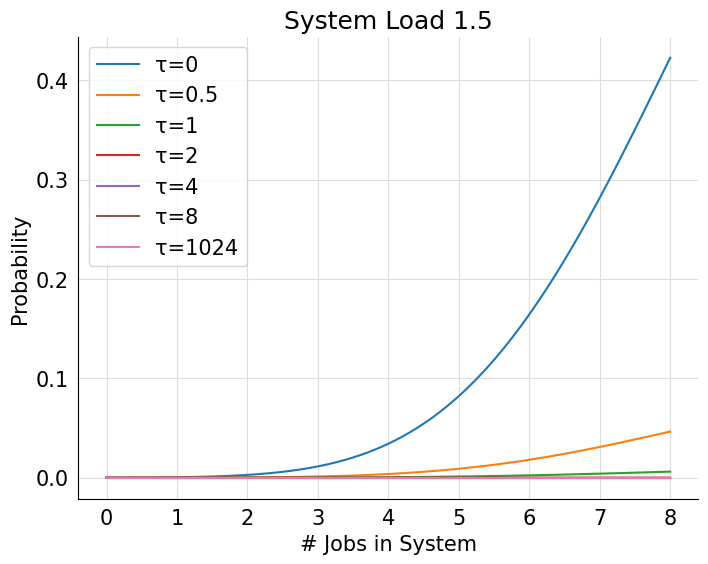

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

def system_probability(lmbda, c, mu, tau, k):
    pho = lmbda/mu
    alpha = mu * tau
    
    summation =  sum([(pho**k / factorial(k)) for k in range(c+1)])
    if pho==c:
        p0 = (summation + alpha * (pho**(c+1))/factorial(c))
        p0 = p0**-1
    else:
        p0 = summation + (pho**(c+1)/((pho-c)*factorial(c))) * (np.exp(alpha*(pho-c))-1)
        p0 = p0**-1
    
    if k <= c:
        return (lmbda**k)*p0/((mu**k)*factorial(k))
    else:
        print("hi")
        return 0

c = 8
mu = 1

k_values = np.linspace(0, 8, 1000)
tau_values = [0, 0.5, 1, 2, 4, 8, 1024]

def plotting_settings(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    #ax.spines['bottom'].set_color('#DDDDDD')
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#DDDDDD')
    ax.xaxis.grid(True, color='#DDDDDD')

jobs_in_system = 6
for lmbda in [c*0.2, c*0.5, c*0.8, c*1, c*1.2, c*1.5]:
    
    system_util = lmbda/(mu*c) 
    fig, ax = plt.subplots(figsize=(8, 6))
    plotting_settings(ax)
    for tau in tau_values:
        prob_values = [system_probability(lmbda, c, mu, tau, k=kk) for kk in k_values]
        p = plt.plot(k_values, prob_values, label=f'τ={tau}')
    
    
    plt.legend()
    plt.xlabel('# Jobs in System')
    #plt.xlabel('Average Waiting Time')
    plt.ylabel('Probability')
    plt.title(f'System Load {system_util}')
    plt.show()
# plt.xlabel('Waiting Time (τ/μ)')
# plt.ylabel('Cost Reduction over No Wait')

# fig.tight_layout()
# plt.savefig('figures/theoretical_cost_savings.pdf')
# plt.show()

Text(0, 0.5, 'Cost Savings over No-Wait')

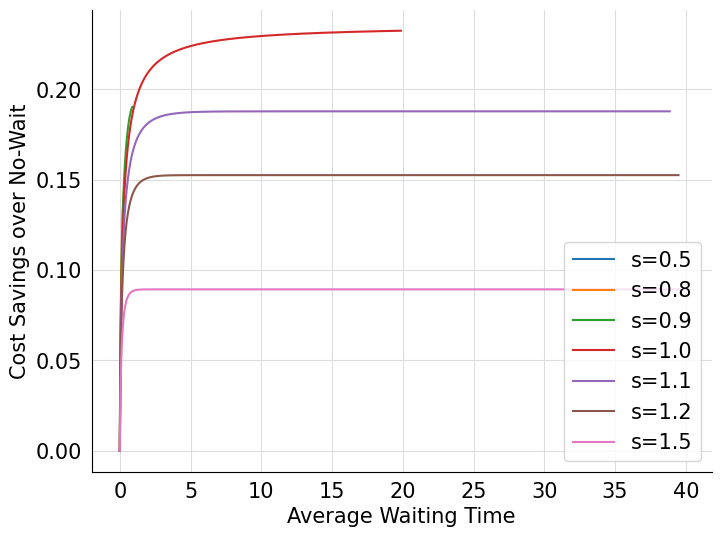

In [52]:
c = 8
mu = 1
tau_values = np.linspace(0, 40, 2000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for lmbda in [c*0.5, c*0.8,c*0.9, c*1, c*1.1, c*1.2, c*1.5]:
    system_util = lmbda/(mu*c)
    cloud_cost_values = [(renege_probability(lmbda, c, mu, 0) - renege_probability(lmbda, c, mu, tau)) for tau in tau_values]
    jct_values = [average_wait_time(lmbda, c, mu, tau) for tau in tau_values]
    plt.plot(jct_values, cloud_cost_values, label=f's={system_util}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('Average Waiting Time')
plt.ylabel('Cost Savings over No-Wait')

Text(0, 0.5, 'Average Waiting Times')

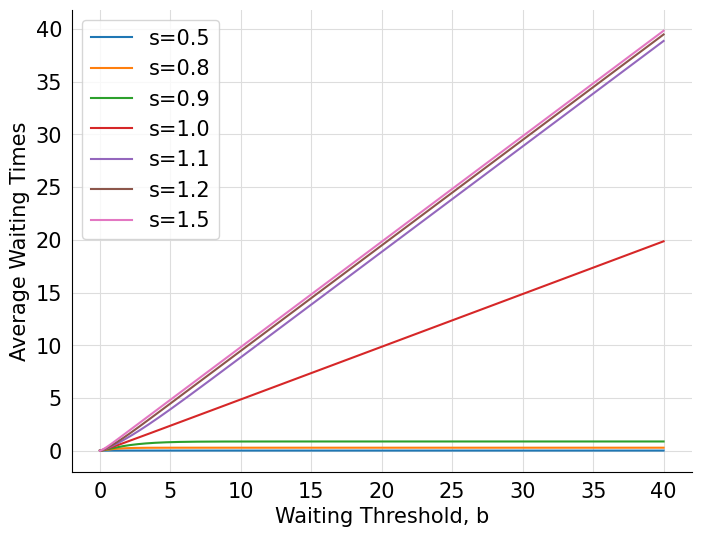

In [54]:
c = 8
mu = 1
tau_values = np.linspace(0, 40, 2000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for lmbda in [c*0.5, c*0.8,c*0.9, c*1, c*1.1, c*1.2, c*1.5]:
    system_util = lmbda/(mu*c)
    jct_values = [average_wait_time(lmbda, c, mu, tau) for tau in tau_values]
    plt.plot(tau_values, jct_values, label=f's={system_util}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('Waiting Threshold, b')
plt.ylabel('Average Waiting Times')

Text(0, 0.5, 'Cloud Cost')

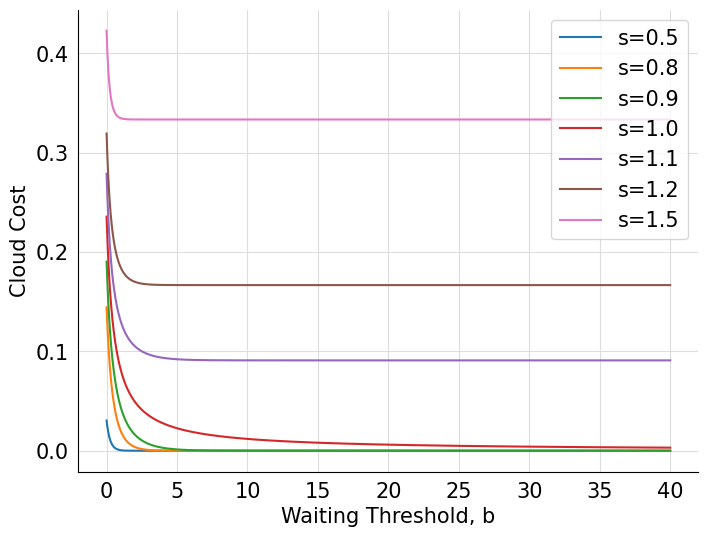

In [56]:
c = 8
mu = 1
tau_values = np.linspace(0, 40, 2000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for lmbda in [c*0.5, c*0.8,c*0.9, c*1, c*1.1, c*1.2, c*1.5]:
    system_util = lmbda/(mu*c)
    cloud_cost_values = [renege_probability(lmbda, c, mu, tau) for tau in tau_values]
    jct_values = [average_wait_time(lmbda, c, mu, tau) for tau in tau_values]
    plt.plot(tau_values, cloud_cost_values, label=f's={system_util}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('Waiting Threshold, b')
plt.ylabel('Cloud Cost')

Text(0, 0.5, 'Average Waiting Time')

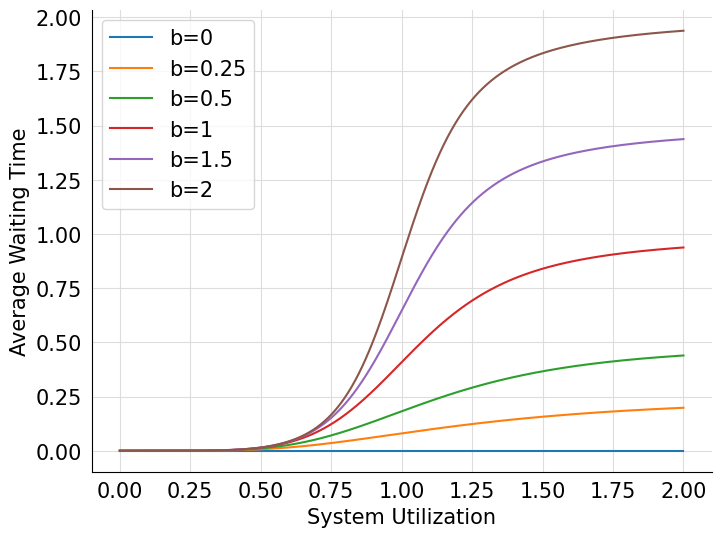

In [60]:
c = 8
mu = 1
system_values = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for tau in [0, 0.25, 0.5, 1, 1.5, 2]:
    system_util = lmbda/(mu*c)
    cloud_cost_values = [renege_probability(s*mu*c, c, mu, tau) for s in system_values]
    jct_values = [average_wait_time(s*mu*c, c, mu, tau, with_balk=False) for s in system_values]
    plt.plot(system_values, jct_values, label=f'b={tau}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('System Utilization')
plt.ylabel('Average Waiting Time')

/tmp/ipykernel_26844/2085276073.py:21: RuntimeWarning: invalid value encountered in scalar divide
  cloud_cost_values = [(renege_probability(s*mu*c, c, mu, 0) - renege_probability(s*mu*c, c, mu, tau))/(renege_probability(s*mu*c, c, mu, 0)) for s in system_values]


Text(0, 0.5, 'Cost Saving w.r.t. No-Wait')

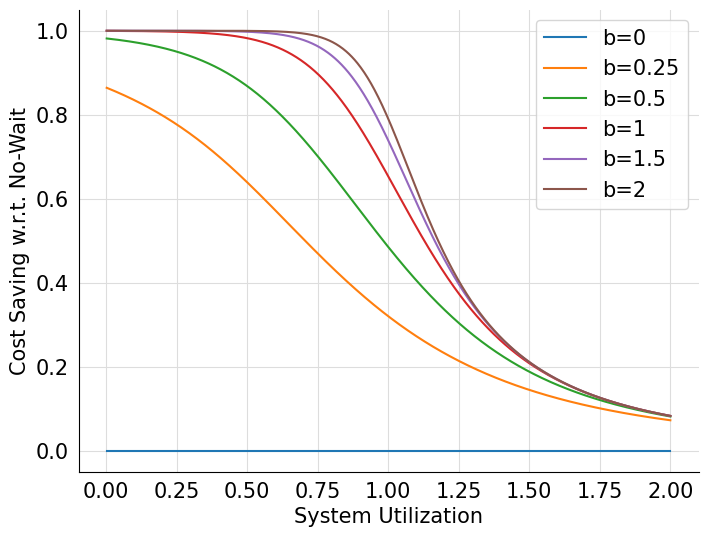

In [64]:
c = 8
mu = 1
system_values = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for tau in [0, 0.25, 0.5, 1, 1.5, 2]:
    system_util = lmbda/(mu*c)
    cloud_cost_values = [(renege_probability(s*mu*c, c, mu, 0) - renege_probability(s*mu*c, c, mu, tau))/(renege_probability(s*mu*c, c, mu, 0)) for s in system_values]
    jct_values = [average_wait_time(s*mu*c, c, mu, tau, with_balk=True) for s in system_values]
    plt.plot(system_values, cloud_cost_values, label=f'b={tau}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('System Utilization')
plt.ylabel('Cost Saving w.r.t. No-Wait')

/tmp/ipykernel_26844/4228930436.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return p0 * (pho*(c*pho)**c)/(lmbda*((1-pho)**2)*factorial(c))


Text(0, 0.5, 'Cloud Cost')

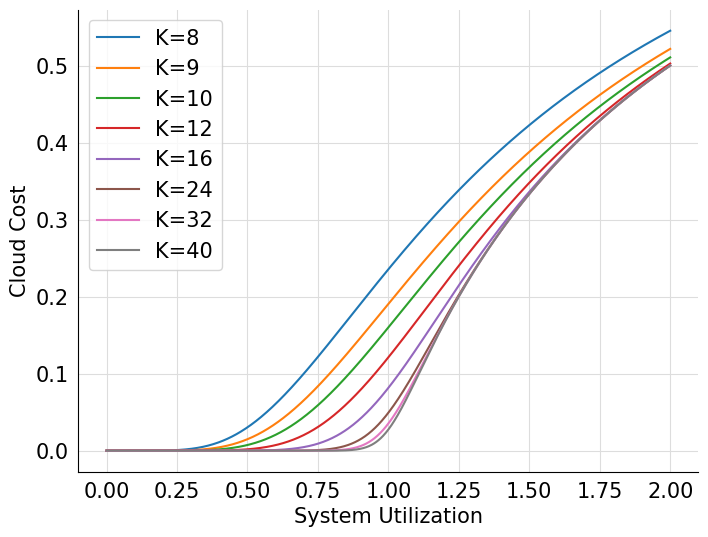

In [82]:
c = 8
mu = 1

def renege_probability(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    
    pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
    return pK

def average_wait_time(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    return p0 * (pho*(c*pho)**c)/(lmbda*((1-pho)**2)*factorial(c))
    







system_values = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for tau in [0, 1, 2, 4, 8, 16, 24, 32]:
    tau = c + tau
    system_util = lmbda/(mu*c)
    cloud_cost_values = [renege_probability(s*mu*c, c, mu, tau) for s in system_values]
    jct_values = [average_wait_time(s*mu*c, c, mu, tau) for s in system_values]
    plt.plot(system_values, cloud_cost_values, label=f'K={tau}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('System Utilization')
plt.ylabel('Cloud Cost')

/tmp/ipykernel_26844/2946055964.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return p0 * (pho*(c*pho)**c)/(lmbda*((1-pho)**2)*factorial(c))


Text(0, 0.5, 'Cost Savings')

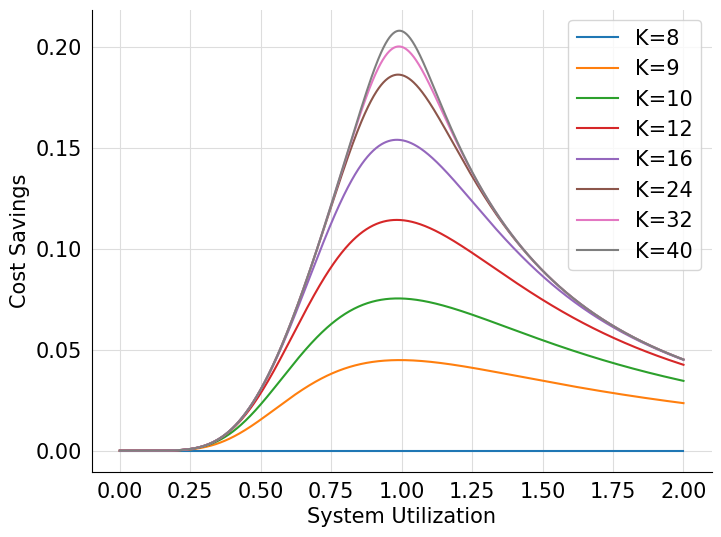

In [120]:
c = 8
mu = 1

def renege_probability(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    
    pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
    return pK

def average_wait_time(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    return p0 * (pho*(c*pho)**c)/(lmbda*((1-pho)**2)*factorial(c))
    







system_values = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for tau in [0, 1, 2, 4, 8, 16, 24, 32]:
    tau = c + tau
    system_util = lmbda/(mu*c)
    cloud_cost_values = [renege_probability(s*mu*c, c, mu, 8) - renege_probability(s*mu*c, c, mu, tau) for s in system_values]
    jct_values = [average_wait_time(s*mu*c, c, mu, tau) for s in system_values]
    plt.plot(system_values, cloud_cost_values, label=f'K={tau}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('System Utilization')
plt.ylabel('Cost Savings')

/tmp/ipykernel_26844/473368710.py:52: RuntimeWarning: invalid value encountered in scalar divide
  cloud_cost_values = [(renege_probability(s*mu*c, c, mu, 8) - renege_probability(s*mu*c, c, mu, tau))/renege_probability(s*mu*c, c, mu, 8) for s in system_values]
/tmp/ipykernel_26844/473368710.py:24: RuntimeWarning: invalid value encountered in scalar divide
  return Q/(lmbda * (1 - pK))


Text(0, 0.5, 'Cloud Cost')

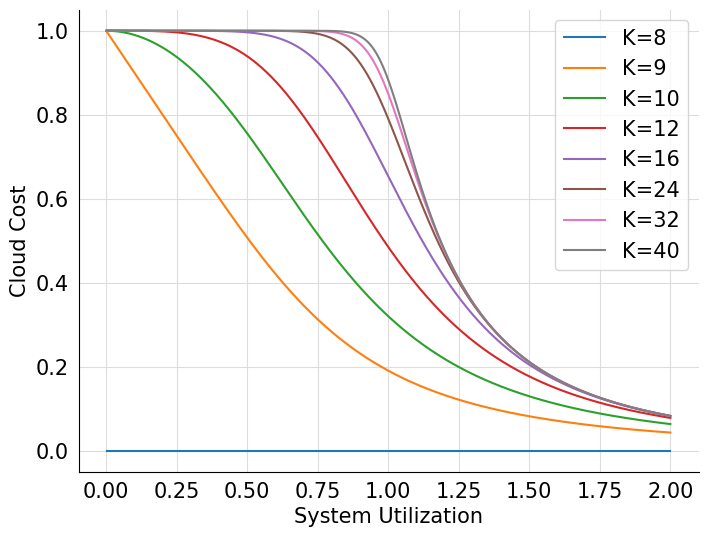

In [104]:
c = 8
mu = 1

def renege_probability(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    
    pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
    return pK

def average_wait_time(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
    
    r = lbmda/(mu*c)
    Q = (((pho)**c)*r*p0/(factorial(c)*(1-r)**2)) * (1 + (K-c)*(r**(K-c+1)) - (K-c+1)*(r**(K-c)))
    return Q/(lmbda * (1 - pK))
    







system_values = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for tau in [0, 1, 2, 4, 8, 16, 24, 32]:
    tau = c + tau
    system_util = lmbda/(mu*c)
    cloud_cost_values = [(renege_probability(s*mu*c, c, mu, 8) - renege_probability(s*mu*c, c, mu, tau))/renege_probability(s*mu*c, c, mu, 8) for s in system_values]
    jct_values = [average_wait_time(s*mu*c, c, mu, tau) for s in system_values]
    plt.plot(system_values, cloud_cost_values, label=f'K={tau}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('System Utilization')
plt.ylabel('% Cost Savings')

/tmp/ipykernel_26844/2578243686.py:24: RuntimeWarning: invalid value encountered in scalar divide
  return L/(lmbda * (1-pK))


Text(0, 0.5, 'Average Waiting Time')

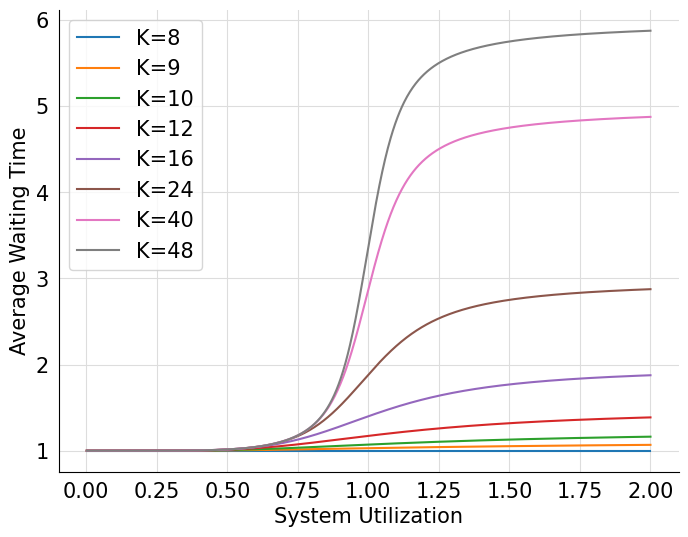

In [110]:
c = 8
mu = 1

def renege_probability(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    
    pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
    return pK

def average_wait_time(lmbda, c, mu, K):
    r = lmbda/mu
    pho = r/c
    if pho/c != 1:
        p0 = (sum([r**i/factorial(i) for i in range(0, c)]) + (r**c/factorial(c))*((1 - (pho)**(K-c+1))/(1 - pho)))**-1   
    else:
        p0 = (sum([r**i/factorial(i) for i in range(0, c)]) + (r**c/factorial(c))*(K-c+1))**-1
    pK = ((r**K)*p0)/(factorial(c)*(c**(K-c)))
    Lq = ((p0 * (r**c) * pho)/(factorial(c)*(1-pho)**2))*(1 - pho**(K-c+1) - (1-pho)*(K-c+1)*pho**(K-c))
    L = Lq + r*(1-pK)
    return L/(lmbda * (1-pK))
#     pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
#     pho = lmbda/(c*mu)
#     term_a = sum([(lmbda**k)/(factorial(k) * mu**k) for k in range(c)])
#     term_b = sum([(lmbda**(k-c)/((mu**(k-c)) * (c**(k-c)))) for k in range(c+1, K+1)])
#     pi_0 = (term_a + (lmbda**c)*term_b/((mu**c)*factorial(c))  )**-1
#     return pi_0 * (pho*(c*pho)**c)/(lmbda*((1-pho)**2)*factorial(c))
    

system_values = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for tau in [0, 1, 2, 4, 8, 16, 32, 40]:
    tau = c + tau
    system_util = lmbda/(mu*c)
    #cloud_cost_values = [(renege_probability(s*mu*c, c, mu, 8) - renege_probability(s*mu*c, c, mu, tau))/renege_probability(s*mu*c, c, mu, 8) for s in system_values]
    jct_values = [average_wait_time(s*mu*c, c, mu, tau) for s in system_values]
    plt.plot(system_values, jct_values, label=f'K={tau}')
    
plt.legend()
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('System Utilization')
plt.ylabel('Average Waiting Time')

/tmp/ipykernel_26844/1400632537.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  Lq = ((p0 * (r**c) * pho)/(factorial(c)*(1-pho)**2))*(1 - pho**(K-c+1) - (1-pho)*(K-c+1)*pho**(K-c))
/tmp/ipykernel_26844/1400632537.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  Lq = ((p0 * (r**c) * pho)/(factorial(c)*(1-pho)**2))*(1 - pho**(K-c+1) - (1-pho)*(K-c+1)*pho**(K-c))


Text(0, 0.5, 'Cloud Cost')

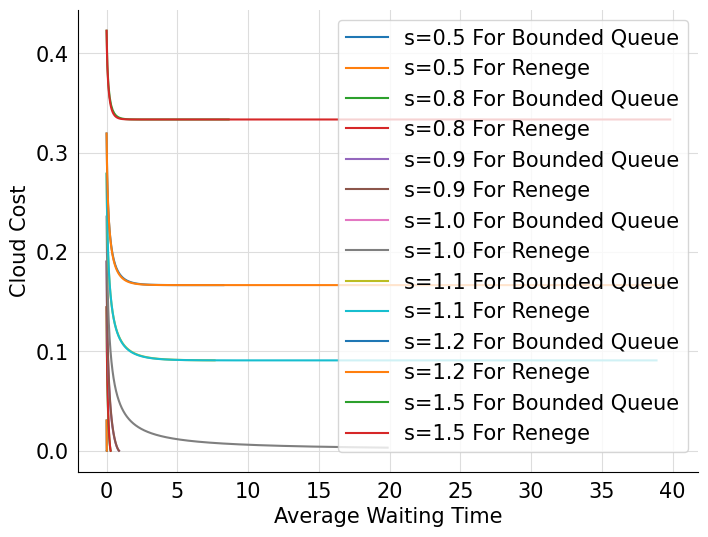

In [123]:
c = 8
mu = 1

def renege_probability(lmbda, c, mu, K):
    pho = lmbda/mu
    if pho/c != 1:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*((1 - (pho/c)**(K-c+1))/(1 - pho/c)))**-1   
    else:
        p0 = (sum([pho**i/factorial(i) for i in range(0, c)]) + (pho**c/factorial(c))*(K-c+1))**-1
    
    pK = ((pho**K)*p0)/(factorial(c)*(c**(K-c)))
    return pK

def average_wait_time(lmbda, c, mu, K):
    r = lmbda/mu
    pho = r/c
    if pho != 1:
        p0 = (sum([r**i/factorial(i) for i in range(0, c)]) + (r**c/factorial(c))*((1 - (pho)**(K-c+1))/(1 - pho)))**-1   
    else:
        p0 = (sum([r**i/factorial(i) for i in range(0, c)]) + (r**c/factorial(c))*(K-c+1))**-1
    pK = ((r**K)*p0)/(factorial(c)*(c**(K-c)))
    Lq = ((p0 * (r**c) * pho)/(factorial(c)*(1-pho)**2))*(1 - pho**(K-c+1) - (1-pho)*(K-c+1)*pho**(K-c))
    L = Lq + r*(1-pK)
    return L/(lmbda * (1-pK)) -1



def renege_probability_1(lmbda, c, mu, tau):
    r = lmbda/mu
    if r==c:
        numerator = (c**c / factorial(c)) * np.exp(-mu * tau * (c - r))
        denominator_sum = sum([(c**k / factorial(k)) for k in range(c)])
        last_term = (r**c / factorial(c)) * (1 + c*mu*tau)
        denominator = denominator_sum + last_term
        return numerator/denominator
    numerator = (r**c / factorial(c)) * np.exp(-mu * tau * (c - r))
    denominator_sum = sum([(r**k / factorial(k)) for k in range(c)])
    last_term = (r**c / factorial(c)) * (r * np.exp(-mu * tau * (c - r)) - c) / (r - c)
    denominator = denominator_sum + last_term
    return numerator / denominator


def average_wait_time_1(lmbda, c, mu, tau, with_balk=False):
    intensity = lmbda/(c*mu)
    
    delta = (c*mu - lmbda)
    p = (lmbda/mu)**c/ (sum([((lmbda/mu)**k / factorial(k)) for k in range(c+1)])*factorial(c))
    beta = (c*mu*p)/(1-p)
    if intensity!=1:
        alpha = (beta*(1/delta - np.exp(-delta*tau) * lmbda/(delta*c*mu)) + 1)**-1
    elif intensity==1:
        alpha = lmbda / (lmbda + beta * lmbda * tau + beta)
    
    r = (alpha * beta * np.exp(-delta * tau)) / (c*mu)
    
    if intensity!=1:
        avg_wait_time = (alpha*beta*(1-delta*tau*np.exp(-delta*tau) - np.exp(-delta*tau)))/(delta)**2 + r*tau
    else:
        avg_wait_time = alpha*beta*(tau)**2/2 + r*tau
    
    if with_balk:
        avg_wait_time -= r*tau
    
    return avg_wait_time

K_values = list(range(8, 80))
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 15})

ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
#ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(True)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(True, color='#DDDDDD')


for lmbda in [c*0.5, c*0.8,c*0.9, c*1, c*1.1, c*1.2, c*1.5]:
    system_util = lmbda/(mu*c)
    cloud_cost_values = [renege_probability(lmbda, c, mu, tau) for tau in K_values]
    jct_values = [average_wait_time(lmbda, c, mu, tau) for tau in K_values]
    tau_values = np.linspace(0, 40, 2000)
    cloud_cost_values_1 = [renege_probability_1(lmbda, c, mu, tau) for tau in tau_values]
    jct_values_1 = [average_wait_time_1(lmbda, c, mu, tau) for tau in tau_values]
    plt.plot(jct_values, cloud_cost_values, label=f's={system_util} For Bounded Queue')
    plt.plot(jct_values_1, cloud_cost_values_1, label=f's={system_util} For Renege')
    
plt.legend()

#ax.axvline(x=0.25)
# for lbmda in [mu*c*0.5, mu*c*0.8, mu*c*1.2, mu*c*1.5]:
#     y_values = [(average_wait_time(lbmda, c, mu, tau=0) - average_wait_time(lbmda, c, mu, tau=t*mu))/average_wait_time(lbmda, c, mu, tau=0)  for t in tau_values]
#     plt.plot(tau_values, y_values, label=f's={lbmda/(mu*c)}')
# plt.legend()
    

plt.xlabel('Average Waiting Time')
plt.ylabel('Cloud Cost')